### DQN Docking Case

In [2]:
import sys

## !pip install -e ../gym_space_docking/

loc = os.popen('pip3 show gym_space_docking').readlines()[7].split()[1]


sys.path.append(loc)


import gym
import os
import gym_space_docking

In [3]:
# include Network
import tensorflow as tf
import numpy as np

### create enviroment pygame

In [4]:
env = gym.make('space_docking-v0')
#print(env)

pygame 2.1.0 (SDL 2.0.16, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
/Users/denny/Documents/workspace_ironhack/IronHack_Final_Project/gym_space_docking/gym_space_docking/envs


/Users/denny/Documents/workspace_ironhack/IronHack_Final_Project/gym_space_docking/gym_space_docking/envs/space_docking_env.py:55: Warning: no fast renderer available
  self.window_display = pygame.display.set_mode(size=(window_width, window_height),flags= SCREENFLAGS)#, vsync=True)


In [8]:
env.reset()

In [12]:
print(env.action_space)
#print(env.observation_space)
#print(type(env.action_space))

Discrete(7)


In [41]:
for i in range(100):
    map, reward, done, info = env.step(0)

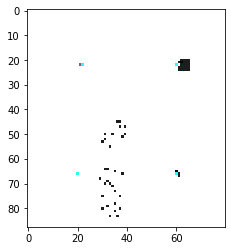

In [42]:
from matplotlib import pyplot as plt
plt.imshow(map, interpolation='nearest')
plt.show()

In [20]:
env.render()

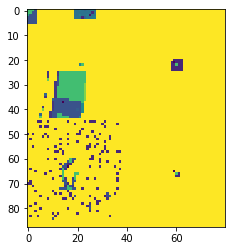

In [21]:
plt.imshow(preprocess_observations(map), interpolation='nearest')
plt.show()

In [7]:
# handle observations

# handle image scaling and resizing to fit the image in input data

def preprocess_observations(obs):
    # ToDo need love to work
    img = obs
    img = img.mean(axis=2)
    img = (img - 128) / 128 -1

    return img.reshape(88,80,1)
    pass

### create DQN network

In [12]:
# create network
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32,64,64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ['SAME'] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10 # 64 maps with size 11x10
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n# -> ToDo define in enviroment 
initializer =  tf.keras.initializers.VarianceScaling()# tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.01


In [13]:
tf.compat.v1.disable_eager_execution()

def q_network(X_state, name):
    prev_layer = X_state
    with tf.compat.v1.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
            conv_n_maps, conv_kernel_sizes, conv_strides,
            conv_paddings, conv_activation):
            
            prev_layer = tf.compat.v1.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size= kernel_size,
                strides= strides, padding=padding, activation=activation,
                kernel_initializer= initializer)
            
            last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
            
            hidden = tf.compat.v1.layers.dense(last_conv_layer_flat, n_hidden, 
                                                activation=hidden_activation,
                                                kernel_initializer=initializer)
            
            outputs = tf.compat.v1.layers.dense(hidden, n_outputs, 
                                                kernel_initializer=initializer)
        
        trainable_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, 
                                                    scope=scope.name)
        
        trainable_vars_by_name = {var.name[len(scope.name):] : var for var in trainable_vars}

        return outputs, trainable_vars_by_name
            


In [14]:
X_state = tf.compat.v1.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])
online_q_values, online_vars = q_network(X_state=X_state, name='q_networks/online')
target_q_values, target_vars = q_network(X_state=X_state, name='q_networks/target')

copy_obs = [target_var.assign(online_vars[var_name]) for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_obs)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '


In [15]:
X_action = tf.compat.v1.placeholder(tf.int32, shape=[None])
q_value = tf.reduce_sum(target_q_values * tf.one_hot(X_action, n_outputs), axis=1, keepdims=True)

In [16]:
y = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
error = tf.abs(y - q_value)
clipped_error = tf.clip_by_value(error, 0.0, 1.0)
linear_error = 2*(error - clipped_error)
loss = tf.compat.v1.reduce_mean(tf.square(clipped_error) +linear_error)

In [17]:
global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate=learning_rate,name='momentum', momentum=0.9, use_nesterov=True)
training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

### tools

In [18]:
from collections import deque

replay_memory_size = 500000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indicies = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], []] # state, action, rewards, next_state, continue
    for idx in indicies:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1,1))

In [19]:
# actor explore enviroment

eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return np.argmax(q_values)


### run training

In [20]:
n_steps = 4000000
training_start = 10000
training_interval = 4
save_steps = 1000
copy_steps = 10000
discont_rate = 0.99
skip_start = 90
batch_size = 50
iteration = 0
checkpoint_path = './docking_dqn.ckpt'
done = True


In [21]:
with tf.compat.v1.Session() as sess:
    if os.path.isfile(checkpoint_path + '.index'):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        if done:
            obs = env.reset()
            for skip in range(skip_start):
                obs, reward, done, info = env.step(0)
            state = preprocess_observations(obs)

        # online dqn evaluate
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # online dqn play
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observations(obs)

        # remember what happend
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals

        # get probe from memory
        # use target dqn to get target q value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size=batch_size))
        
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_state_val})

        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discont_rate * max_next_q_values

        # train online dqn
        training_op.run(feed_dict={X_state: X_state_val, X_action: X_action_val, y: y_val})

        # copy online dqn to target dqn
        if step % copy_steps == 0:
            copy_online_to_target.run()
        
        # save regulary
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

2021-12-12 17:00:51.246717: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-12 17:00:51.319098: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


(18, 5) astro_85
(18, 4) astro_85
(19, 3) astro_85
(17, 4) astro_85
(17, 4) astro_85
(19, 3) astro_85
(20, 2) astro_85
(19, 4) astro_85
(20, 4) astro_85
(20, 3) astro_85
(22, 3) astro_85
(22, 4) astro_85
(21, 4) astro_85
(21, 5) astro_85
(16, 5) astro_85
(17, 4) astro_85
(18, 4) astro_85
(16, 4) astro_85
(16, 4) astro_85
(16, 4) astro_85
(14, 4) astro_85
(14, 4) astro_85
(7, 4) astro_85
(7, 4) astro_85
(11, 3) astro_85
(10, 2) astro_85
(9, 2) astro_85
(7, 2) astro_85
(7, 1) astro_85
(4, 2) astro_85
(1, 2) astro_85
(1, 3) astro_85
(1, 3) astro_85
(1, 3) astro_85
(1, 3) astro_85
(1, 4) astro_85
(21, 26) astro_94
(20, 24) astro_94
(20, 21) astro_94
(20, 18) astro_94
(18, 17) astro_94
(18, 14) astro_94
(16, 14) astro_94
(16, 11) astro_94
(15, 10) astro_94
(14, 9) astro_94
(12, 8) astro_94
(12, 7) astro_94
(10, 6) astro_94
(10, 5) astro_94
(8, 5) astro_94
(7, 4) astro_94
(5, 3) astro_94
(5, 3) astro_94
(5, 2) astro_94
(3, 3) astro_94
(5, 3) astro_94
(5, 2) astro_94
(5, 2) astro_94
(4, 3) as

KeyboardInterrupt: 

##### cool, actally no big errors....time to work on the enviroment, passing the right values